In [1]:
#install dependencies
# !pip install pyarrow
# !pip install  duckdb --upgrade --pre
# !pip install wittgenstein


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split,  GroupShuffleSplit
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, matthews_corrcoef

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.model_selection import GridSearchCV

import os
import time

## Duck Db imports
import pyarrow.parquet as pq
import duckdb

# developed packages
from utils import create_facts_and_examples, performance_metrics



## Import Data¶


#### create duck db connection

In [3]:
con = duckdb.connect(':memory:')
# enable automatic query parallelization
con.execute("PRAGMA threads=2")
# enable caching of parquet metadata
con.execute("PRAGMA enable_object_cache")

#### Reading PAYSIM1 data and creating parquet file

In [4]:
try:
    con.sql('DROP TABLE df_fraud_tbl')
    print("previous table dropped")
except:
    pass

try:
    con.sql("""CREATE TABLE fraud_tbl AS SELECT * FROM 'fraud.parquet';""")
except:
    con.sql(
    """
    copy 'DATA/paysim1/PS_20174392719_1491204439457_log.csv' to 'fraud.parquet';
""")
    con.sql("""CREATE TABLE fraud_tbl AS SELECT * FROM 'fraud.parquet';""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

#### Creating externarl origin and destination, Imputing zero values for external accounts

In [5]:
df_fraud = con.sql(""" 
SELECT *,
-- evaluating external accounts
    oldbalanceOrg==0 and newbalanceOrig==0 as external_orig,
    oldbalanceDest==0 and newbalanceDest==0 as external_dest,
-- Imputing zero values for external accounts
    CASE WHEN external_orig==True 
        THEN  amount
        ELSE oldbalanceOrg
    END AS oldbalanceOrg_imputed,
    CASE WHEN external_dest==True 
        THEN  amount
        ELSE newbalanceDest
    END AS newbalanceDest_imputed, 
FROM fraud_tbl
""").df()

# testing
slice_index = df_fraud['external_orig']==True

assert np.sum(df_fraud[slice_index]['amount'] != df_fraud[slice_index]['oldbalanceOrg_imputed'] )==0, "Wrong imputation for external origin"

slice_index = df_fraud['external_dest']==True

assert np.sum(df_fraud[slice_index]['amount'] != df_fraud[slice_index]['newbalanceDest_imputed'] )==0, "Wrong imputation for external destination"


## Split data to train/test/val 

#### train and test sets

In [6]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_index, test_index in gss.split(df_fraud, groups=df_fraud['nameDest']):
    df_train_total = df_fraud.loc[train_index]
    df_test_       = df_fraud.loc[test_index]

#### validation set is a part of train set

In [7]:
df_train_total = df_train_total.reset_index(drop=True)

gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_index, val_index in gss.split(df_train_total, groups=df_train_total['nameDest']):
    df_train_ = df_train_total.loc[train_index]
    df_val_   = df_train_total.loc[val_index]

# Preprocessing

#### aggregation definition
compute average, and maximum amount of transfer for the last 3, and 7 days for the destination 

In [8]:
def aggregates(df):
    """ runs aggregations on pandas dataframe with help of duckdb"""
    data = df.copy()
    data = data.sort_values(by='step')
    data=data.reset_index(drop=True).reset_index()
    data = con.sql("""
        SELECT 
            *,

-- calculate aggregetions (Average and Max) for last 7 including the current row for each name Destination
            AVG(amount) OVER (PARTITION BY nameDest ORDER BY index ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS mean_last_7,
            MAX(amount) OVER (PARTITION BY nameDest ORDER BY index ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS max_last_7,
       
-- calculate aggregetions (Average and Max) for last 3 including the current row for each name Destination
            AVG(amount) OVER (PARTITION BY nameDest ORDER BY index ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS mean_last_3,
            MAX(amount) OVER (PARTITION BY nameDest ORDER BY index ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS max_last_3,

-- deviation from the aggregated values
            amount-mean_last_7 as deviation_from_mean_7_days,
            amount-mean_last_3 as deviation_from_mean_3_days,
            amount-max_last_7 as deviation_from_max_7_days,
            amount-max_last_3 as deviation_from_max_3_days,

        FROM 
            data
            ORDER BY index
            """).df()
    
    return data

#### Preprocessing class fit on train data and processes 

In [9]:
class Preprocess:
    def __init__(self, scaler_columns):

        self.scaler = StandardScaler()

        self.scaler_columns = scaler_columns
        
    def fit(self, train_data_frame):
        
        self.scaler.fit(train_data_frame[self.scaler_columns])
        
    def transform(self, data_frame):
        
        df = data_frame.copy()
        
        #scale numerical columns 
        df[self.scaler_columns] = self.scaler.transform(df[self.scaler_columns])
        
        ### run aggregation
        df = aggregates(df)
        
        # one hot encoding and drop columns 
        df['distType'] = df["nameDest"].str[0]
        df = pd.get_dummies(df, columns=['type', "distType"])
        df.drop(columns=["step", "nameOrig", "nameDest", "isFlaggedFraud"], inplace=True)

        
        return df

    
columns = ['amount', 'oldbalanceOrg_imputed', 'newbalanceOrig', 'oldbalanceDest',
   'newbalanceDest_imputed']

preprocessor = Preprocess(scaler_columns=columns)

preprocessor.fit(df_train_)

#### prerocessing 

In [10]:
df_train = preprocessor.transform(df_train_)
df_test = preprocessor.transform(df_test_)
df_val = preprocessor.transform(df_val_)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

#### performance

In [11]:
def performance(model, x_test, y_test):
    """ evaluetes performance of the model"""
    y_pred = model.predict(x_test)
    performance_metrics(y_pred, y_test, labels=model.classes_)

## Decision Tree

In [12]:
X_train = df_train.drop(columns=['isFraud'])
y_train = df_train['isFraud']
X_test = df_test.drop(columns=['isFraud'])
y_test = df_test['isFraud']

X_val = df_val.drop(columns=['isFraud'])
y_val = df_val['isFraud']

In [13]:
# hyper parameter tuning

dtc_model=DecisionTreeClassifier(random_state=42)

parameters = {'max_leaf_nodes': range(3,9,1)}
gs_clf = GridSearchCV(dtc_model, parameters, cv=5, scoring='matthews_corrcoef')

features = ['amount', 'external_dest', 'oldbalanceOrg_imputed', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest_imputed', 'deviation_from_max_7_days',
       'deviation_from_max_3_days', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER']

gs_clf.fit(X_val[features], y_val)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': range(3, 9)},
             scoring='matthews_corrcoef')

In [14]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
print('grid search score, cv=5,', gs_clf.best_score_)

max_leaf_nodes: 8
grid search score, cv=5, 0.5061408455889455


In [15]:
dtc_model=gs_clf.best_estimator_
dtc_model.fit(X_train[features],y_train)
dtc_prediction=dtc_model.predict(X_test[features])

Accuracy: 0.999528
Precision TP/(TP+FP): 0.971098
Recall TP/(TP+FN): 0.665083
F1 Score: 0.789474
MCC Score: 0.803454


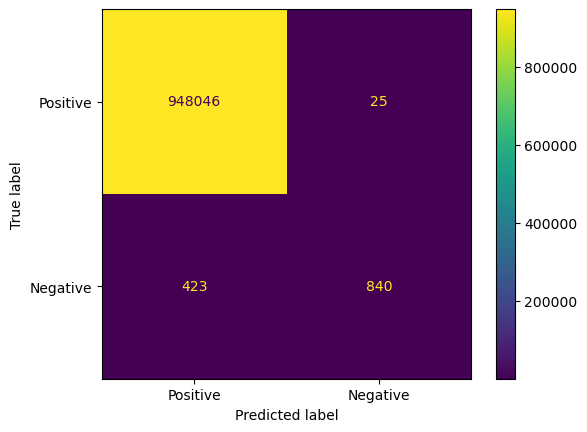

In [16]:
performance(dtc_model, x_test=X_test[features], y_test=y_test)

[Text(0.5769230769230769, 0.9, 'amount <= 3.079\ngini = 0.003\nsamples = 4599530\nvalue = [4593585, 5945]\nclass = y[0]'),
 Text(0.3076923076923077, 0.7, 'type_TRANSFER <= 0.5\ngini = 0.002\nsamples = 4568369\nvalue = [4563640, 4729]\nclass = y[0]'),
 Text(0.15384615384615385, 0.5, 'amount <= 1.297\ngini = 0.001\nsamples = 4213050\nvalue = [4210651, 2399]\nclass = y[0]'),
 Text(0.07692307692307693, 0.3, 'gini = 0.001\nsamples = 4212296\nvalue = [4210301, 1995]\nclass = y[0]'),
 Text(0.23076923076923078, 0.3, 'oldbalanceDest <= -0.007\ngini = 0.497\nsamples = 754\nvalue = [350, 404]\nclass = y[1]'),
 Text(0.15384615384615385, 0.1, 'gini = 0.138\nsamples = 348\nvalue = [26, 322]\nclass = y[1]'),
 Text(0.3076923076923077, 0.1, 'gini = 0.322\nsamples = 406\nvalue = [324, 82]\nclass = y[0]'),
 Text(0.46153846153846156, 0.5, 'external_dest <= 0.5\ngini = 0.013\nsamples = 355319\nvalue = [352989, 2330]\nclass = y[0]'),
 Text(0.38461538461538464, 0.3, 'gini = 0.0\nsamples = 352934\nvalue = [35

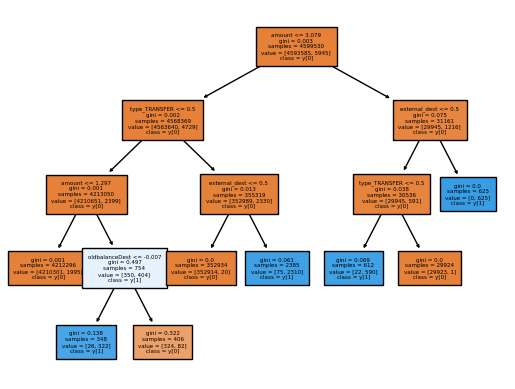

In [17]:
plot_tree(dtc_model, feature_names=dtc_model.feature_names_in_, filled=True, fontsize=4, class_names=True)

In [31]:
def create_cart_predicates(cart_model, input_df):
    """ Creates data frame with columns from decision tree features and thresholds feature<threshold"""
    bool_filter         = cart_model.tree_.feature>=0
    chosen_features_id  = cart_model.tree_.feature[bool_filter]
    chosen_features     = cart_model.feature_names_in_[chosen_features_id]
    thresholds          = cart_model.tree_.threshold[bool_filter]
    features_thresholds = list(set(list(zip(chosen_features, thresholds))))
    df = pd.DataFrame()
    for ft in features_thresholds:
        df[str(ft).replace('(','{').replace(')','}').replace('\'','')] = input_df[ft[0]]<=ft[1]
        
    df['isFraud'] = input_df['isFraud']
    predicates = df.columns[:-1]
    return df, predicates

train_predicates_cart, predicates = create_cart_predicates(dtc_model, df_train)
test_predicates_cart,a = create_cart_predicates(dtc_model, df_test)

create_facts_and_examples(df_=train_predicates_cart, target='isFraud', \
                          predicates=predicates, output_dir='examples/fraud-cart')

test_predicates_cart.to_parquet(path='examples/fraud-cart/df_test.parquet')

isFraud
[    201     864     877 ... 4599527 4599528 4599529]
{amount, 1.2966257333755493}
[      0       1       2 ... 4599523 4599526 4599529]
{type_TRANSFER, 0.5}
[      0       1       2 ... 4599525 4599528 4599529]
{amount, 3.0788129568099976}
[      0       1       2 ... 4599525 4599526 4599529]
{oldbalanceDest, -0.0067258847411721945}
[      0       1       2 ... 4599526 4599527 4599528]
{external_dest, 0.5}
[     11      12      14 ... 4599525 4599528 4599529]


In [20]:
#short version
df_1 = train_predicates_cart[train_predicates_cart['isFraud']==0]
df_2 = train_predicates_cart[train_predicates_cart['isFraud']==1]
fraud_background = pd.concat([df_1.iloc[0:100], df_2.iloc[0:100]], ignore_index=True)
create_facts_and_examples(df_=fraud_background, target='isFraud', \
                          predicates=predicates, output_dir='examples/fraud-cart-short')

test_predicates_cart.to_parquet(path='examples/fraud-cart-short/df_test.parquet')

isFraud
[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199]
{amount, 1.2966257333755493}
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  49  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 115 116 117 118 119 120 121 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 147 

## Prepare background knowledge, positive, and negative examples for DILP

In [19]:
df_1 = df_train[df_train['isFraud']==0]
df_2 = df_train[df_train['isFraud']==1]
fraud_background = pd.concat([df_1.iloc[0:100], df_2.iloc[0:100]], ignore_index=True)
#  type = transfer, and
# • externalDest = True, and
# • amount - maxDest7 > -0.15
fraud_background['deviation_from_max_7_days'] = fraud_background['deviation_from_max_7_days']>-0.15
predicates=['external_dest', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT',
                                       'type_TRANSFER', 'deviation_from_max_7_days']

create_facts_and_examples(df_=fraud_background, target='isFraud', 
                          predicates=predicates, output_dir='examples/fraud')

df_test.to_parquet(path='examples/fraud/df_test.parquet')


isFraud
[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199]
external_dest
[  0   1   2   3   4   5   6   7   8   9  10  13  22  23  24  25  26  28
  29  30  43  45  46  47  55  56  58  78  79  80  81  82  83  84  85  86
  92  93  94  95  98 100 102 103 105 107 109 111 112 114 116 118 119 121
 123 124 126 127 128 131 132 135 137 138 141 142 145 146 147 150 155 164
 165 167 174 176 179 180 182 186 191 194 197 198]
type_CASH_IN
[61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 87 88 89 90]
type_CASH_OUT
[ 31  32  33  34  35  36  37  38  39  40  41  42  44 101 104 106 108 110
 113 115 117 120 122 125 130 133 134 136 139 140 143 144 148 149

In [20]:
assert 0, "break before ripper"

AssertionError: break before ripper

## RIPPER

In [ ]:
import wittgenstein as lw

In [ ]:
#https://pypi.org/project/wittgenstein/
#https://www.geeksforgeeks.org/ripper-algorithm/
#https://github.com/imoscovitz/wittgenstein#useful-references
ripper_clf = lw.RIPPER() # Or irep_clf = lw.IREP() to build a model using IREP
ripper_clf.fit(X_train,y_train) # Or pass X and y data to .fit
ripper_clf

In [ ]:
ripper_clf.out_model()

In [ ]:
performance(ripper_clf, x_test=X_test, y_test=y_test)